<a href="https://colab.research.google.com/github/sauravsingla/Multi-Class-Sentiment-Classification-/blob/main/twitter_tsvd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Bidirectional, GRU, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
import time
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import KernelPCA
from pandas import DataFrame
import re
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/My Drive/NLP/text_emotion.csv")
df = df.drop(["tweet_id","author"],axis = 1)
print(df.head())

    sentiment                                            content
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...


In [ ]:
df.drop(df[df['sentiment'] == 'empty'].index, inplace = True)
df.drop(df[df['sentiment'] == 'enthusiasm'].index, inplace = True)
df['target'] = df['sentiment'].map({'sadness':0, 'boredom':1,'neutral':2,'worry':3,'surprise':4,'love':5,'fun':6,'hate':7,'happiness':8,'anger':9,'relief':10})
df = df.drop(["sentiment"],axis=1)
print(df.head())

                                             content  target
1  Layin n bed with a headache  ughhhh...waitin o...       0
2                Funeral ceremony...gloomy friday...       0
4  @dannycastillo We want to trade with someone w...       2
5  Re-pinging @ghostridah14: why didn't you go to...       3
6  I should be sleep, but im not! thinking about ...       0


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"didn't", "did not", text)
    return text

In [ ]:
cleaned_text = []
for text in df['content']:
    cleaned_text.append(clean_text(text))
df['clean'] = cleaned_text
df.head()

,content,target,clean
1,Layin n bed with a headache ughhhh...waitin o...,0,layin n bed with a headache ughhhh...waitin o...
2,Funeral ceremony...gloomy friday...,0,funeral ceremony...gloomy friday...
4,@dannycastillo We want to trade with someone w...,2,@dannycastillo we want to trade with someone w...
5,Re-pinging @ghostridah14: why didn't you go to...,3,re-pinging @ghostridah14: why did not you go t...
6,"I should be sleep, but im not! thinking about ...",0,"i should be sleep, but im not! thinking about ..."


In [ ]:
tw = []
for j in df['clean']:
  tweets = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", str(j)).split())
  tw.append(tweets)

In [ ]:
df['clean'] = tw
df.head()

,content,target,clean
1,Layin n bed with a headache ughhhh...waitin o...,0,layin n bed with a headache ughhhh waitin on y...
2,Funeral ceremony...gloomy friday...,0,funeral ceremony gloomy friday
4,@dannycastillo We want to trade with someone w...,2,we want to trade with someone who has houston ...
5,Re-pinging @ghostridah14: why didn't you go to...,3,re pinging why did not you go to prom bc my bf...
6,"I should be sleep, but im not! thinking about ...",0,i should be sleep but im not thinking about an...


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
output = []
for sentence in df["clean"]:
    temp_list = []
    for word in sentence.split():
      if len(word) > 2 not in stopwords:
        temp_list.append(word)
    output.append(' '.join(temp_list))
    
df["texts"] = output
df.drop(['content','clean'], axis = 1)

,target,texts
1,0,layin bed with headache ughhhh waitin your call
2,0,funeral ceremony gloomy friday
4,2,want trade with someone who has houston ticket...
5,3,pinging why did not you prom did not like friends
6,0,should sleep but not thinking about old friend...
...,...,...
39995,2,
39996,5,happy mothers day all love
39997,5,happy mother day all the mommies out there you...
39998,8,wassup beautiful follow peep out new hit singl...


In [ ]:
df = df.drop(['content','clean'], axis =1)
df.head()

,target,texts
1,0,layin bed with headache ughhhh waitin your call
2,0,funeral ceremony gloomy friday
4,2,want trade with someone who has houston ticket...
5,3,pinging why did not you prom did not like friends
6,0,should sleep but not thinking about old friend...


In [ ]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(texts):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(texts)]


df['text_lemmatized'] = df.texts.apply(lemmatize_text)

sc = [[' '.join(i)] for i in df['text_lemmatized']]
lis = []
for i in sc:
    abc = i[0]
    lis.append(abc)

df['lem'] = lis
df.head()

,target,texts,text_lemmatized,lem
1,0,layin bed with headache ughhhh waitin your call,"[layin, bed, with, headache, ughhhh, waitin, y...",layin bed with headache ughhhh waitin your call
2,0,funeral ceremony gloomy friday,"[funeral, ceremony, gloomy, friday]",funeral ceremony gloomy friday
4,2,want trade with someone who has houston ticket...,"[want, trade, with, someone, who, ha, houston,...",want trade with someone who ha houston ticket ...
5,3,pinging why did not you prom did not like friends,"[pinging, why, did, not, you, prom, did, not, ...",pinging why did not you prom did not like friend
6,0,should sleep but not thinking about old friend...,"[should, sleep, but, not, thinking, about, old...",should sleep but not thinking about old friend...


In [ ]:
df = df.drop(['text_lemmatized','texts'], axis =1)
df.head()

,target,lem
1,0,layin bed with headache ughhhh waitin your call
2,0,funeral ceremony gloomy friday
4,2,want trade with someone who ha houston ticket ...
5,3,pinging why did not you prom did not like friend
6,0,should sleep but not thinking about old friend...


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
X = df["lem"]
Y = df["target"]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size = 0.30)
Yt = np_utils.to_categorical(Ytrain)
Yt

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
tokenizer_inputs = Tokenizer(num_words=2000)
tokenizer_inputs.fit_on_texts(Xtrain)
word2idx_inputs = tokenizer_inputs.word_index
word2idx_inputs['SOS'] = 0
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 21814 unique input tokens.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=2000,vocabulary = word2idx_inputs)

Xtrain = tfidf.fit_transform(Xtrain)

Xtrain = pd.DataFrame(Xtrain.toarray())
Xtrain = Xtrain.to_numpy()

from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=200)
Xtrain = tsvd.fit(Xtrain).transform(Xtrain)
Xtrain
# pca = KernelPCA(n_components=100, kernel='rbf')
# abc = pca.fit_transform(data)

array([[ 0.18283779, -0.0700744 , -0.09715766, ..., -0.01685376,
         0.00347506,  0.01299288],
       [ 0.1816091 ,  0.10265931, -0.08084395, ..., -0.01005099,
         0.0242204 , -0.00045246],
       [ 0.11656073, -0.06129664, -0.04354654, ...,  0.00787842,
        -0.00890394, -0.00073819],
       ...,
       [ 0.0480683 , -0.02635731,  0.01268506, ...,  0.0039069 ,
         0.03191859,  0.03144123],
       [ 0.2029253 , -0.06256147, -0.1352502 , ...,  0.01787983,
        -0.00769224,  0.00718393],
       [ 0.09559535, -0.0371355 , -0.00283907, ..., -0.00922295,
         0.03080878, -0.0276215 ]])

In [ ]:
input_ = Input(shape=(200,1))
x = Bidirectional(GRU(64, return_sequences=True))(input_)
x = Dropout(0.2)(x)
x = Bidirectional(GRU(48, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(24,activation="relu")(x)
output = Dense(11, activation="softmax")(x)
model = Model(input_, output)

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)

In [ ]:
print('Training model...')
r = model.fit(
  Xtrain,
  Yt,
  batch_size=64,
  epochs=50,
  validation_split=0.4
)

Training model...
Epoch 1/50
253/253 [==============================] - 14s 57ms/step - loss: 2.0696 - accuracy: 0.2277 - val_loss: 2.0395 - val_accuracy: 0.2274
Epoch 2/50
253/253 [==============================] - 13s 53ms/step - loss: 2.0106 - accuracy: 0.2286 - val_loss: 2.0181 - val_accuracy: 0.2344
Epoch 3/50
253/253 [==============================] - 13s 52ms/step - loss: 2.0064 - accuracy: 0.2359 - val_loss: 2.0210 - val_accuracy: 0.2295
Epoch 4/50
253/253 [==============================] - 13s 52ms/step - loss: 2.0024 - accuracy: 0.2367 - val_loss: 2.0102 - val_accuracy: 0.2384
Epoch 5/50
253/253 [==============================] - 13s 52ms/step - loss: 1.9969 - accuracy: 0.2441 - val_loss: 2.0019 - val_accuracy: 0.2421
Epoch 6/50
253/253 [==============================] - 13s 52ms/step - loss: 1.9924 - accuracy: 0.2461 - val_loss: 1.9973 - val_accuracy: 0.2411
Epoch 7/50
253/253 [==============================] - 13s 52ms/step - loss: 1.9895 - accuracy: 0.2562 - val_loss: 2.00

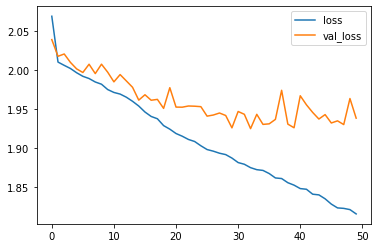

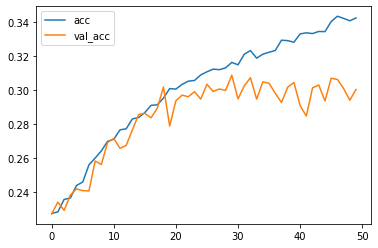

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
Xtest = tfidf.fit_transform(Xtest)
Xtest = pd.DataFrame(Xtest.toarray())
Xtest = Xtest.to_numpy()
Xtest = tsvd.fit(Xtest).transform(Xtest)

p = model.predict(Xtest)
print(p)
p = np.argmax(p, axis=1)
print(p)

from sklearn.metrics import confusion_matrix
cnfv=confusion_matrix(Ytest,p)
print(cnfv)

from sklearn.metrics import classification_report
print(classification_report(Ytest, p))

[[0.14952713 0.01280597 0.27195996 ... 0.08453423 0.00627599 0.05025619]
 [0.14667074 0.00921646 0.19393632 ... 0.09162169 0.00722679 0.03443255]
 [0.19505164 0.00879193 0.08779635 ... 0.1384288  0.00525794 0.07777108]
 ...
 [0.0408422  0.00154251 0.12207859 ... 0.24862738 0.0018949  0.05934634]
 [0.27786916 0.01076774 0.08677942 ... 0.09753888 0.0058496  0.0626109 ]
 [0.07067497 0.00270554 0.23641416 ... 0.13461031 0.00125678 0.0687926 ]]
[3 3 3 ... 5 3 3]
[[  83    0  215  943    0  154    0    4  201    0    0]
 [   3    0   10   34    0    4    0    0    5    0    0]
 [  86    0  603 1460    0  145    0    6  248    0    0]
 [ 112    0  360 1597    0  183    0    3  283    0    0]
 [  24    0  107  390    0   49    0    4   78    0    0]
 [  40    0  115  588    0  196    0    4  190    0    0]
 [  21    0   66  345    0   42    0    0   82    0    0]
 [  21    0   55  242    0   27    0    2   49    0    0]
 [  73    0  211  850    0  119    0    2  298    0    0]
 [   0    0    7

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
